In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score,cross_val_predict, KFold
from sklearn.svm import SVC
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score, classification_report, roc_curve, auc
import lightgbm as lgb
import warnings

In [7]:
# Model with basic features only

# Load the processed dataset
file_path = 'model_data.csv'
data = pd.read_csv(file_path)

# Create the target variable based on shot_outcome
data['shot_outcome'] = data['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)

# Drop the columns that are not needed for the model
data = data.drop(columns=['location', 'shot_speed', 'statsbomb_xg', 'possession_team', 'player', 'goalkeeper_location', 'goalkeeper_distance', 'defensive_pressure'])

# Handle categorical variables including 'position'
data = pd.get_dummies(data, drop_first=True)

# Define the features and target variable
X = data.drop(columns=['shot_outcome'])
y = data['shot_outcome']

# Scale the features using Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Function to evaluate models using cross-validation
def evaluate_model_cv(model, X, y):
    y_pred_prob = cross_val_predict(model, X, y, cv=10, method='predict_proba')[:, 1]
    log_loss_score = log_loss(y, y_pred_prob)
    roc_auc = roc_auc_score(y, y_pred_prob)
    y_pred = cross_val_predict(model, X, y, cv=10)
    report = classification_report(y, y_pred)
    
    return log_loss_score, roc_auc, report

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_loss_lr, roc_auc_lr, report_lr = evaluate_model_cv(lr_model, X_scaled, y)
print(f'Logistic Regression - Log Loss (10-fold CV): {log_loss_lr}')
print(f'Logistic Regression - ROC AUC Score (10-fold CV): {roc_auc_lr}')
print('Logistic Regression - Classification Report:')
print(report_lr)

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
log_loss_xgb, roc_auc_xgb, report_xgb = evaluate_model_cv(xgb_model, X_scaled, y)
print(f'XGBoost - Log Loss (10-fold CV): {log_loss_xgb}')
print(f'XGBoost - ROC AUC Score (10-fold CV): {roc_auc_xgb}')
print('XGBoost - Classification Report:')
print(report_xgb)

# Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
log_loss_rf, roc_auc_rf, report_rf = evaluate_model_cv(rf_model, X_scaled, y)
print(f'Random Forest - Log Loss (10-fold CV): {log_loss_rf}')
print(f'Random Forest - ROC AUC Score (10-fold CV): {roc_auc_rf}')
print('Random Forest - Classification Report:')
print(report_rf)

# Support Vector Machine
svm_model = SVC(probability=True, class_weight='balanced')
log_loss_svm, roc_auc_svm, report_svm = evaluate_model_cv(svm_model, X_scaled, y)
print(f'Support Vector Machine - Log Loss (10-fold CV): {log_loss_svm}')
print(f'Support Vector Machine - ROC AUC Score (10-fold CV): {roc_auc_svm}')
print('Support Vector Machine - Classification Report:')
print(report_svm)


Logistic Regression - Log Loss (10-fold CV): 0.5187877675809289
Logistic Regression - ROC AUC Score (10-fold CV): 0.7960576028830505
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1496
           1       0.30      0.70      0.42       184

    accuracy                           0.79      1680
   macro avg       0.63      0.75      0.65      1680
weighted avg       0.88      0.79      0.82      1680

XGBoost - Log Loss (10-fold CV): 0.3779634540832566
XGBoost - ROC AUC Score (10-fold CV): 0.7579995931178795
XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1496
           1       0.48      0.27      0.35       184

    accuracy                           0.89      1680
   macro avg       0.70      0.62      0.64      1680
weighted avg       0.87      0.89      0.87      1680

Random Forest - Log Loss (

Features being analyzed in the model:
['distance_to_goal', 'angle_to_goal', 'minute', 'shot_one_on_one', 'shot_first_time', 'position_Forward', 'position_Goalkeeper', 'position_Midfielder', 'play_pattern_From Counter', 'play_pattern_From Free Kick', 'play_pattern_From Goal Kick', 'play_pattern_From Keeper', 'play_pattern_From Kick Off', 'play_pattern_From Throw In', 'play_pattern_Penalty', 'play_pattern_Regular Play', 'shot_body_part_Head', 'shot_body_part_Other']
Logistic Regression - Best Parameters: {'C': 0.1, 'solver': 'saga'}
Logistic Regression - Log Loss (10-fold CV): 0.5163890917073181
Logistic Regression - ROC AUC Score (10-fold CV): 0.7966533945594049
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      1496
           1       0.30      0.68      0.42       184

    accuracy                           0.79      1680
   macro avg       0.63      0.75      0.65      1680
weighted avg 

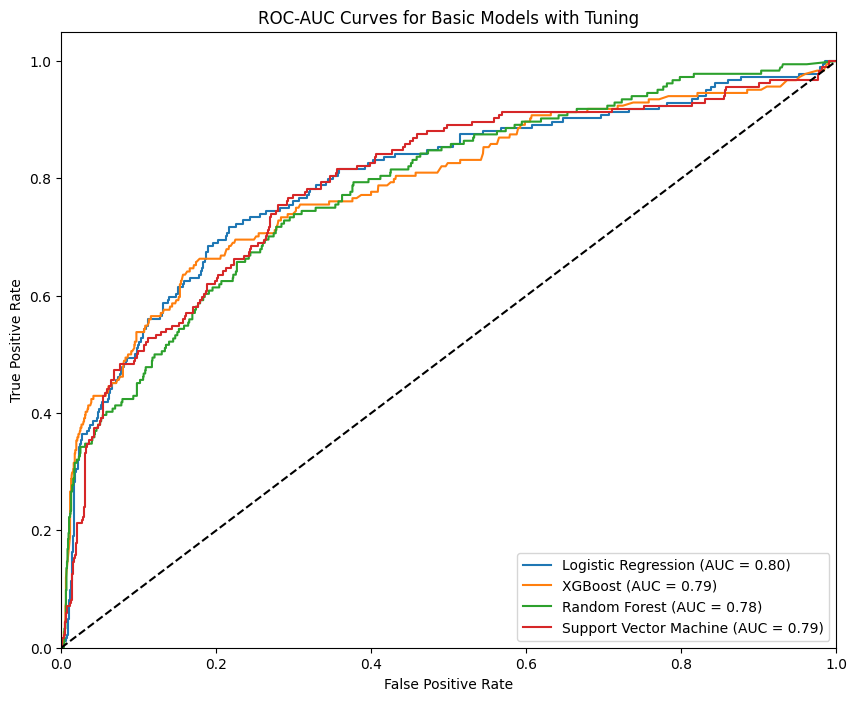

In [5]:
# Model with Basic features and hyperparameter tuning

# Load the processed dataset
file_path = 'model_data.csv'
data = pd.read_csv(file_path)

# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Create the target variable based on shot_outcome
data['shot_outcome'] = data['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)

# Drop the columns that are not needed for the model
data = data.drop(columns=['location', 'shot_speed', 'statsbomb_xg', 'possession_team', 'player', 'goalkeeper_location', 'goalkeeper_distance', 'defensive_pressure'])

# Handle categorical variables including 'position'
data = pd.get_dummies(data, drop_first=True)

# Define the features and target variable
X = data.drop(columns=['shot_outcome'])
y = data['shot_outcome']

# Scale the features using Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Print the features being used in the model
print("Features being analyzed in the model:")
print(X.columns.tolist())

# Function to evaluate models using cross-validation
def evaluate_model_cv(model, X, y):
    y_pred_prob = cross_val_predict(model, X, y, cv=10, method='predict_proba')[:, 1]
    log_loss_score = log_loss(y, y_pred_prob)
    roc_auc = roc_auc_score(y, y_pred_prob)
    y_pred = cross_val_predict(model, X, y, cv=10)
    report = classification_report(y, y_pred)
    
    # Generate ROC curve data
    fpr, tpr, _ = roc_curve(y, y_pred_prob)
    roc_auc_value = auc(fpr, tpr)
    
    return log_loss_score, roc_auc, report, fpr, tpr, roc_auc_value

# Hyperparameter grids
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6]
}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# List to store ROC curve data for plotting
roc_data = []

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
grid_search_lr = GridSearchCV(lr_model, param_grid_lr, cv=10, scoring='neg_log_loss')
grid_search_lr.fit(X_scaled, y)
best_lr_model = grid_search_lr.best_estimator_
log_loss_lr, roc_auc_lr, report_lr, fpr_lr, tpr_lr, auc_lr = evaluate_model_cv(best_lr_model, X_scaled, y)
roc_data.append(('Logistic Regression', fpr_lr, tpr_lr, auc_lr))
print(f'Logistic Regression - Best Parameters: {grid_search_lr.best_params_}')
print(f'Logistic Regression - Log Loss (10-fold CV): {log_loss_lr}')
print(f'Logistic Regression - ROC AUC Score (10-fold CV): {roc_auc_lr}')
print('Logistic Regression - Classification Report:')
print(report_lr)

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=10, scoring='neg_log_loss')
grid_search_xgb.fit(X_scaled, y)
best_xgb_model = grid_search_xgb.best_estimator_
log_loss_xgb, roc_auc_xgb, report_xgb, fpr_xgb, tpr_xgb, auc_xgb = evaluate_model_cv(best_xgb_model, X_scaled, y)
roc_data.append(('XGBoost', fpr_xgb, tpr_xgb, auc_xgb))
print(f'XGBoost - Best Parameters: {grid_search_xgb.best_params_}')
print(f'XGBoost - Log Loss (10-fold CV): {log_loss_xgb}')
print(f'XGBoost - ROC AUC Score (10-fold CV): {roc_auc_xgb}')
print('XGBoost - Classification Report:')
print(report_xgb)

# Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=10, scoring='neg_log_loss')
grid_search_rf.fit(X_scaled, y)
best_rf_model = grid_search_rf.best_estimator_
log_loss_rf, roc_auc_rf, report_rf, fpr_rf, tpr_rf, auc_rf = evaluate_model_cv(best_rf_model, X_scaled, y)
roc_data.append(('Random Forest', fpr_rf, tpr_rf, auc_rf))
print(f'Random Forest - Best Parameters: {grid_search_rf.best_params_}')
print(f'Random Forest - Log Loss (10-fold CV): {log_loss_rf}')
print(f'Random Forest - ROC AUC Score (10-fold CV): {roc_auc_rf}')
print('Random Forest - Classification Report:')
print(report_rf)

# Support Vector Machine
svm_model = SVC(probability=True, class_weight='balanced')
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=10, scoring='neg_log_loss')
grid_search_svm.fit(X_scaled, y)
best_svm_model = grid_search_svm.best_estimator_
log_loss_svm, roc_auc_svm, report_svm, fpr_svm, tpr_svm, auc_svm = evaluate_model_cv(best_svm_model, X_scaled, y)
roc_data.append(('Support Vector Machine', fpr_svm, tpr_svm, auc_svm))
print(f'Support Vector Machine - Best Parameters: {grid_search_svm.best_params_}')
print(f'Support Vector Machine - Log Loss (10-fold CV): {log_loss_svm}')
print(f'Support Vector Machine - ROC AUC Score (10-fold CV): {roc_auc_svm}')
print('Support Vector Machine - Classification Report:')
print(report_svm)

# Plot ROC-AUC curves for all models
plt.figure(figsize=(10, 8))
for model_name, fpr, tpr, roc_auc_value in roc_data:
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_value:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curves for Basic Models with Tuning')
plt.legend(loc='lower right')
plt.show()
